In [1]:
library(tidyverse)
library(chisq.posthoc.test)
options(stringsAsFactors = F)
setwd("../../../../Fetal_metaQTL/")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# Functions

In [2]:
`%notin%` <- Negate(`%in%`)

# Data Loading

In [3]:
readxl::excel_sheets("data/manuscript/ST6.xlsx")

[1] "README"                  "ST6-1-Module-Genes"     
[3] "ST6-2-All-Enrichment"    "ST6-3-Cell-Enrichment"  
[5] "ST6-4-Common-Enrichment" "ST6-5-Rare-Enrichment"  
[7] "ST6-6-Module-Overlap"

In [4]:
big_enrich_tbl <- readxl::read_xlsx("data/manuscript/ST6.xlsx", "ST6-2-All-Enrichment")
dim(big_enrich_tbl)

mod_net_tbl <- readxl::read_xlsx("data/manuscript/ST6.xlsx", "ST6-1-Module-Genes") %>%
                    mutate(network = str_split(full_dendro_name, "-") %>%
                    map_chr(2)) %>%
                    select(assigned_module, network) %>%
                    rename(module = assigned_module) %>%
                    distinct(.keep_all = TRUE)
dim(mod_net_tbl)

[1] 3720    5

[1] 124   2

In [5]:
big_enrich_tbl <- inner_join(big_enrich_tbl, mod_net_tbl) %>%
                    mutate(fdr = p.adjust(p, "fdr")) %>%
                    mutate(fdr_sig = if_else(fdr <= 0.1, 1, 0))

dim(big_enrich_tbl)

Joining, by = "module"


[1] 3720    8

# Analysis

## Chi-square of enrichment hits by network

In [6]:
cell_enrich_chi_tbl <- big_enrich_tbl %>%
    filter(enrich_method == "cell_type_ORA") %>%
    group_by(network) %>%
    summarize(hit = sum(fdr_sig), no_hit = n() - sum(fdr_sig)) %>%
    column_to_rownames("network")

# Post-hoc analysis to identify main drivers of the significant chi-square
chisq.test(cell_enrich_chi_tbl)
posthoc <- chisq.posthoc.test(cell_enrich_chi_tbl, method = "bonferroni")
posthoc_p_df <- posthoc %>% filter(Value == "p values") %>% select(c(3,4))
rownames(posthoc_p_df) <- (posthoc %>% filter(Value == "p values"))$Dimension
posthoc_p_df


	Pearson's Chi-squared test

data:  cell_enrich_chi_tbl
X-squared = 14.729, df = 5, p-value = 0.01158


,hit,no_hit
,<dbl>,<dbl>
gene,1.000000,1.000000
iso,0.002884,0.002884
tr1,1.000000,1.000000
tr2,1.000000,1.000000
xx,1.000000,1.000000
xy,1.000000,1.000000


In [7]:
rare_enrich_chi_tbl <- big_enrich_tbl %>%
    filter(enrich_method == "rare_logit") %>%
    group_by(network) %>%
    summarize(hit = sum(fdr_sig), no_hit = n() - sum(fdr_sig)) %>%
    column_to_rownames("network")

chisq.test(rare_enrich_chi_tbl)


	Pearson's Chi-squared test

data:  rare_enrich_chi_tbl
X-squared = 6.2347, df = 5, p-value = 0.284


In [8]:
gwas_enrich_chi_tbl <- big_enrich_tbl %>%
    filter(grepl("LDSC",enrich_method)) %>%
    group_by(network) %>%
    summarize(hit = sum(fdr_sig), no_hit = n() - sum(fdr_sig)) %>%
    column_to_rownames("network")

# Post-hoc analysis to identify main drivers of the significant chi-square
chisq.test(gwas_enrich_chi_tbl)
posthoc <- chisq.posthoc.test(gwas_enrich_chi_tbl, method = "bonferroni")
posthoc_p_df <- posthoc %>% filter(Value == "p values") %>% select(c(3,4))
rownames(posthoc_p_df) <- (posthoc %>% filter(Value == "p values"))$Dimension
posthoc_p_df


	Pearson's Chi-squared test

data:  gwas_enrich_chi_tbl
X-squared = 12.766, df = 5, p-value = 0.02567


,hit,no_hit
,<dbl>,<dbl>
gene,1.000000,1.000000
iso,1.000000,1.000000
tr1,0.155201,0.155201
tr2,0.204522,0.204522
xx,1.000000,1.000000
xy,1.000000,1.000000


## Comparison of Rare/Common Enrichment Hits by Cell Type

In [9]:
enrich_groups <- big_enrich_tbl %>%
                    filter(enrich_method == "rare_logit" | enrich_method == "gwas_LDSC") %>%
                    select(enrich_group) %>%
                    pull %>%
                    unique
enrich_groups

cell_types <- big_enrich_tbl %>%
                    filter(enrich_method == "cell_type_ORA") %>%
                    select(enrich_group) %>%
                    pull %>%
                    unique
cell_types

[1] "SCZ_PGC3_2021"       "EA_Lee_2018"         "BP_Mullins_2021"    
 [4] "ADHD_Demontis_2019"  "ASD_Grove_2019"      "ALZ_Jansen_2019"    
 [7] "ASD_SFARI_SYNDROMIC" "ASD_SFARI_CAT1&2"    "SCZ_SCHEMA"         
[10] "BD_BIPEX"            "EPI_25"              "DDD_DECIPHER"       
[13] "EPI_RUZZO"           "ASD_TADA"            "DD_TADA"

[1] "ExN" "NPC" "OPC" "END" "ExD" "PER" "MIC" "ExM" "INT"

In [10]:
cell_group_fisher_res <- tibble()

filt_enrich_tbl <- big_enrich_tbl %>%
                    filter(enrich_method != "gwas_MAGMA") %>%
                    mutate(enrich_method = case_when(enrich_method == "cell_type_ORA" ~ "cell",
                                                     enrich_method == "gwas_LDSC" ~ "common",
                                                     enrich_method == "rare_logit" ~ "rare",
                                                     TRUE ~ "ERROR"))

# For a given cell type, where does variant based enrichment localize?
for (enrich in enrich_groups) {
    for (cell_type in cell_types) {
        # Find modules that have a positive, significant cell type
        mods_with_positive_cell <- filt_enrich_tbl %>%
                                            filter(enrich_group == cell_type) %>%
                                            filter(fdr_sig == 1 & (or > 1 | is.na(or))) %>%
                                            select(module) %>%
                                            pull 

        # Find the variation enrichment proportion in the cell-type modules
        enriched_mods_var_hits <- filt_enrich_tbl %>%
                                        filter(enrich_group == enrich & module %in% mods_with_positive_cell) %>%
                                        mutate(hit = case_when(fdr_sig == 1 & (or > 1 | is.na(or)) ~ 1,
                                                               TRUE ~ 0)) %>%
                                        select(hit) %>%
                                        pull
        
        relative_num_var_in_cell_mods <- c(sum(enriched_mods_var_hits == 0), sum(enriched_mods_var_hits == 1))
        
        # Find the variation enrichment proportion in non-cell-type modules (background)
        unenriched_mods_var_hits <- filt_enrich_tbl %>%
                                        filter(enrich_group == enrich & module %notin% mods_with_positive_cell) %>%
                                        mutate(hit = case_when(fdr_sig == 1 & (or > 1 | is.na(or)) ~ 1,
                                                               TRUE ~ 0)) %>%
                                        select(hit) %>%
                                        pull
        
        relative_num_var_in_non_cell_mods <- c(sum(unenriched_mods_var_hits == 0), sum(unenriched_mods_var_hits == 1))
        
        # Assemble a 2x2 contigency table
        fisher_df <- data.frame(not_cell = relative_num_var_in_non_cell_mods,
                                yes_cell = relative_num_var_in_cell_mods)
        rownames(fisher_df) <- c("no_var", "yes_var")
        
        # Perform Fisher's exact test
        fisher_res <- fisher.test(fisher_df)
        
        # Get enrichment class
        enrich_method <- filt_enrich_tbl %>% filter(enrich_group == enrich) %>% select(enrich_method) %>% pull %>% unique

        cell_group_fisher_res <- bind_rows(cell_group_fisher_res, tibble(enrich_group = enrich,
                                                                         enrich_method = enrich_method,
                                                                         cell_type = cell_type,
                                                                         p = fisher_res$p.value,
                                                                         or = fisher_res$estimate))
    }
}

In [11]:
cell_group_fisher_res <- cell_group_fisher_res %>% mutate(fdr = p.adjust(p, "fdr")) %>% arrange(fdr)
cell_group_fisher_res

enrich_group,enrich_method,cell_type,p,or,fdr
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
SCZ_PGC3_2021,common,ExD,2.985264e-08,9.6546115,2.015053e-06
BP_Mullins_2021,common,ExD,1.519437e-08,10.0917773,2.015053e-06
SCZ_PGC3_2021,common,ExM,1.492216e-07,8.9853760,6.714973e-06
EA_Lee_2018,common,ExM,1.494389e-06,7.1164142,5.043562e-05
EA_Lee_2018,common,ExD,2.682086e-06,6.5390747,7.241631e-05
BP_Mullins_2021,common,ExM,4.922704e-06,6.5816384,1.107608e-04
EPI_RUZZO,rare,ExD,6.519237e-05,14.2913411,1.257281e-03
SCZ_SCHEMA,rare,ExD,2.673895e-04,7.8172763,4.512198e-03
BP_Mullins_2021,common,NPC,6.180215e-04,0.1097159,9.270322e-03


# Manuscript Figures

## Figure S12 - Enrichment by Network

Warning message in corrplot::corrplot(as.matrix(cell_enrich_plot_tbl), method = "pie", :
“col.lim interval too wide, please set a suitable value”


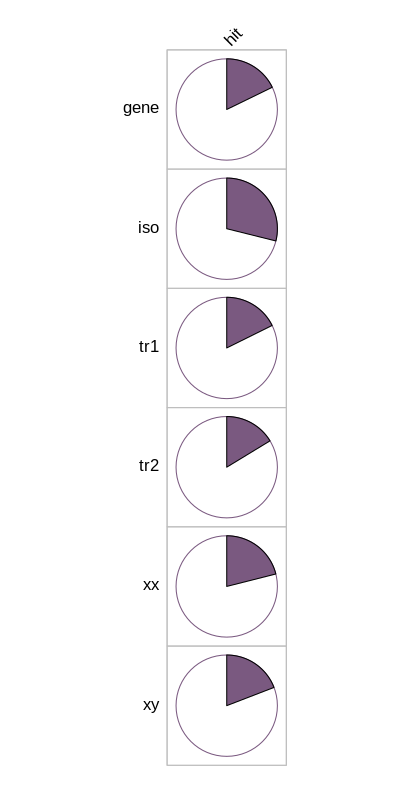

In [12]:
cell_enrich_plot_tbl <- sweep(cell_enrich_chi_tbl, 1, rowSums(cell_enrich_chi_tbl),`/`)
rownames(cell_enrich_plot_tbl) <- c("gene", "iso", "tr1", "tr2", "xx", "xy")
cell_enrich_plot_tbl <- cell_enrich_plot_tbl %>% select(hit)

options(repr.plot.width = 4, repr.plot.height = 8, repr.plot.res = 100)
corrplot::corrplot(as.matrix(cell_enrich_plot_tbl), method = 'pie', is.cor = FALSE,
            mar=c(1,1,1,1), family = "Helvetica",
            cl.pos = "n",
            tl.col = 'black', tl.srt = 45,
            col = "#7A5980", col.lim=c(0, 1))

Warning message in corrplot::corrplot(as.matrix(rare_enrich_plot_tbl), method = "pie", :
“col.lim interval too wide, please set a suitable value”


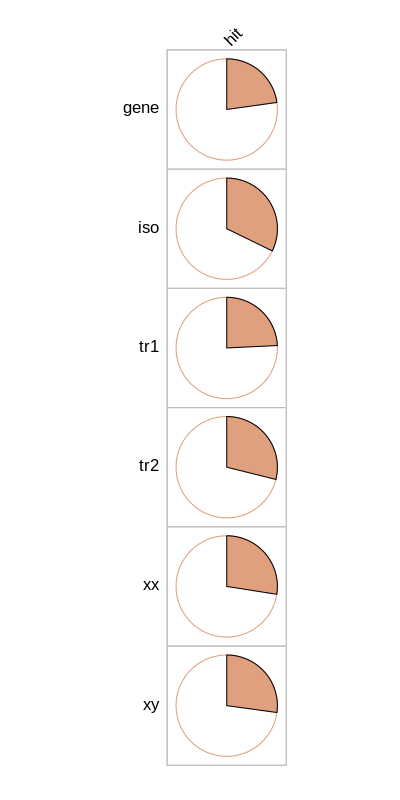

In [13]:
rare_enrich_plot_tbl <- sweep(rare_enrich_chi_tbl, 1, rowSums(rare_enrich_chi_tbl),`/`)
rownames(rare_enrich_plot_tbl) <- c("gene", "iso", "tr1", "tr2", "xx", "xy")
rare_enrich_plot_tbl <- rare_enrich_plot_tbl %>% select(hit)

options(repr.plot.width = 4, repr.plot.height = 8, repr.plot.res = 100)
corrplot::corrplot(as.matrix(rare_enrich_plot_tbl), method = 'pie', is.cor = FALSE,
            mar=c(1,1,1,1), family = "Helvetica",
            cl.pos = "n",
            tl.col = 'black', tl.srt = 45,
            col = "#E09F7D", col.lim=c(0, 1))

Warning message in corrplot::corrplot(as.matrix(common_enrich_plot_tbl), method = "pie", :
“col.lim interval too wide, please set a suitable value”


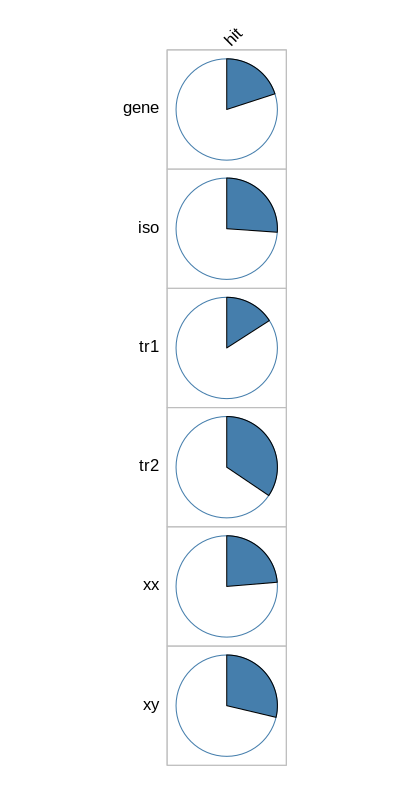

In [14]:
common_enrich_plot_tbl <- sweep(gwas_enrich_chi_tbl, 1, rowSums(gwas_enrich_chi_tbl),`/`)
rownames(common_enrich_plot_tbl) <- c("gene", "iso", "tr1", "tr2", "xx", "xy")
common_enrich_plot_tbl <- common_enrich_plot_tbl %>% select(hit)

options(repr.plot.width = 4, repr.plot.height = 8, repr.plot.res = 100)
corrplot::corrplot(as.matrix(common_enrich_plot_tbl), method = 'pie', is.cor = FALSE,
            mar=c(1,1,1,1), family = "Helvetica",
            cl.pos = "n",
            tl.col = 'black', tl.srt = 45,
            col = "#457EAC", col.lim=c(0, 1))

## Figure S12 - Enrichment by Cell Type

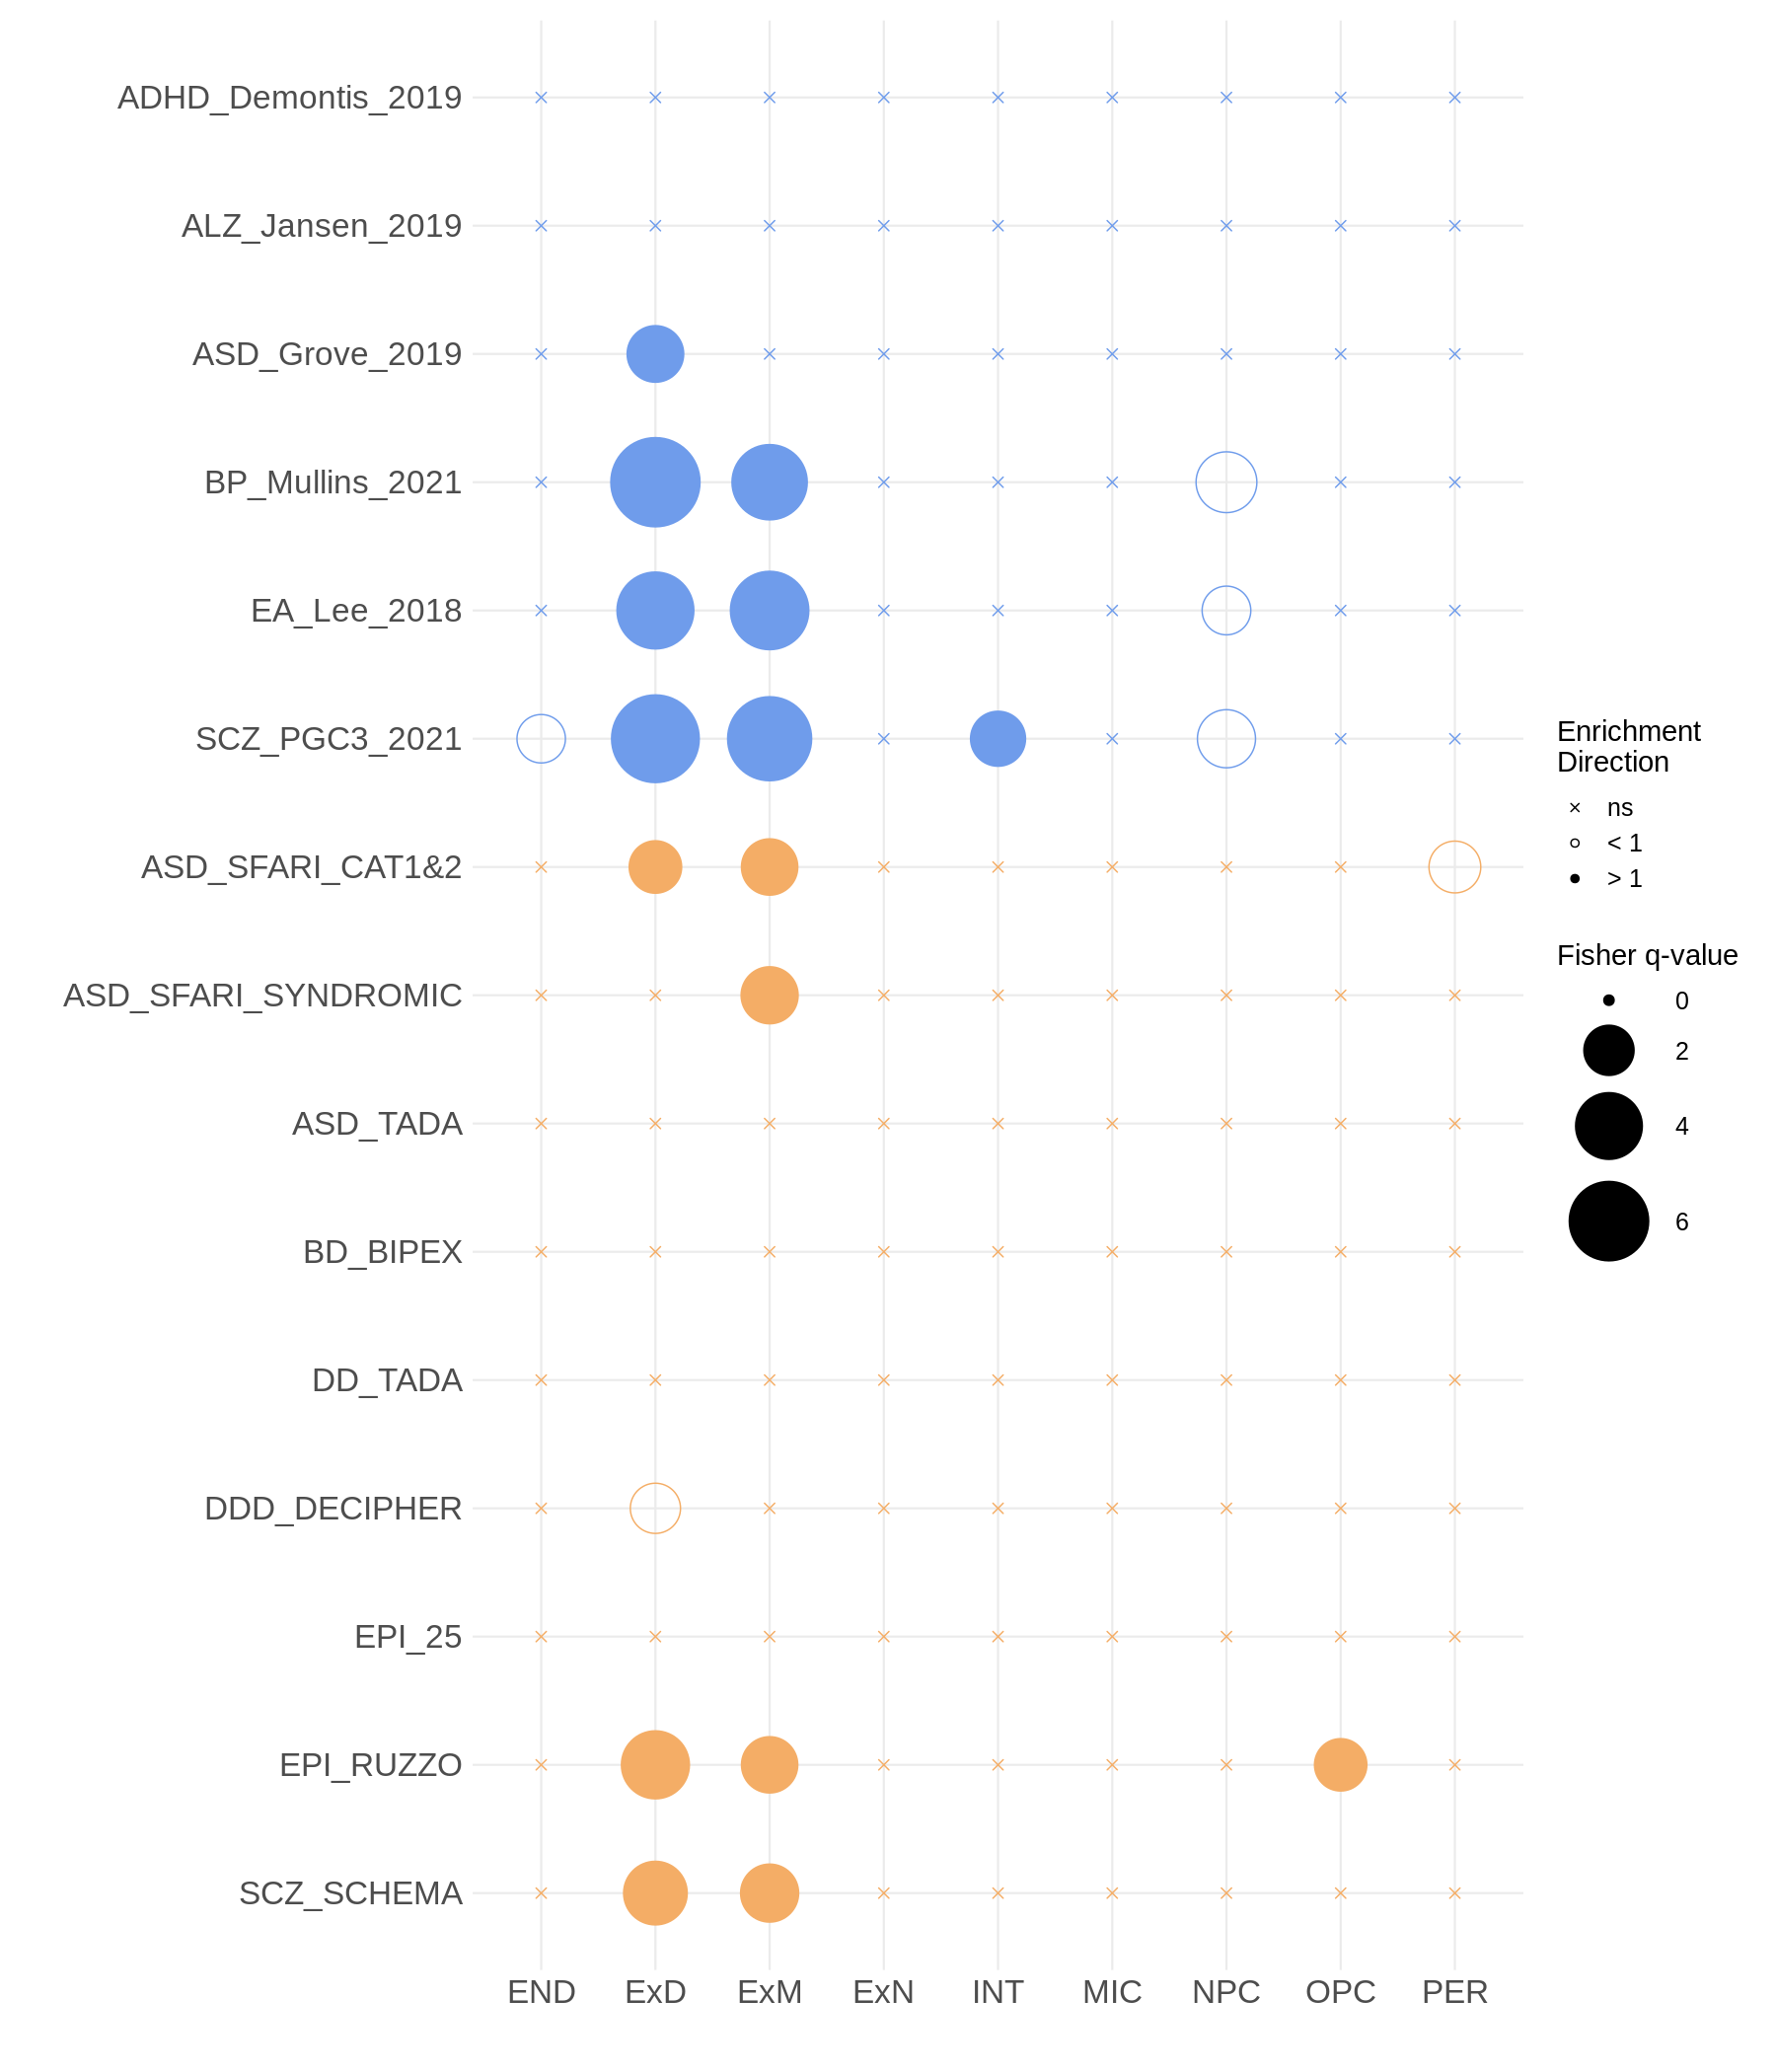

In [15]:
# Custom plot options
options(repr.plot.width = 12, repr.plot.height = 14, repr.plot.res = 150)

# Prepare plot
gg_cell_group_plot_tbl <- cell_group_fisher_res %>%
                            mutate(dir = if_else(or > 1, "> 1", "< 1")) %>%
                            mutate(dir = if_else(fdr > 0.1, "ns", dir)) %>%
                            mutate(plot_or = if_else(dir == "ns", 0.001, or)) %>%
                            mutate(p_log = -log10(p)) %>%
                            mutate(plot_log = if_else(dir == "ns", 0, p_log)) %>%
                            arrange(enrich_method, enrich_group)

gg_cell_group_plot_tbl$enrich_group <- factor(gg_cell_group_plot_tbl$enrich_group, levels = unique(gg_cell_group_plot_tbl$enrich_group))

# Plot
cell_plot <- ggplot(gg_cell_group_plot_tbl, aes(
        x = cell_type,
        y = fct_rev(enrich_group),
        size = plot_log,
        shape = factor(dir, levels = c("ns", "< 1", "> 1")),
        color = enrich_method)) +
    geom_point() +
    theme_minimal() +
    scale_shape_manual(values = c(4,1,19)) +
    scale_color_manual(values = c("#6F9CEB", "#F4AD66")) +
    scale_size(range = c(2,20)) +
    guides(color = "none") + ylab("") + xlab("") +
    theme(text = element_text(size = 20, family="Helvetica"),
          legend.text = element_text(size = 12, family="Helvetica"),
          legend.title = element_text(size = 14, family="Helvetica"),
          #panel.grid.major = element_line(linewidth = 0.25),
          #panel.grid.minor = element_line(linewidth = 0.5),
          #axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1),
          plot.margin = margin(10, 10, 10, 10)) +
    labs(size = "Fisher q-value", color = "Enrichment Class", shape = "Enrichment\nDirection")

cell_plot